###  Devanagari Handwritten data set contains 78,000 train images of hindi characters and 18,000 test images 

### These data stored in folders first we need to collect that data from folders and make a single data file

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import glob
import seaborn as sns

#  next cell take a time be patience

# Preprocessing

In [2]:
path = '../../DataSets/DevanagariHandwrittenCharacterDataset/Train/*'
train_l = []
train_d = [] # pixels 32*32
for label ,folder_name in enumerate(glob.glob(path)):
    for image in (glob.glob(folder_name+'/*')):
        imgdata = plt.imread(image).ravel()  # return (1024,) array  
        train_d.append(imgdata)
        train_l.append(label)

In [3]:
path = '../../DataSets/DevanagariHandwrittenCharacterDataset/Test/*'
test_l = []
test_d = [] # pixels 32*32
for label ,folder_name in enumerate(glob.glob(path)):
    for image in (glob.glob(folder_name+'/*')):
        imgdata = plt.imread(image).ravel()  # return (1024,) array  
        test_d.append(imgdata)
        test_l.append(label)

In [4]:
train_data = np.vstack(train_d)
train_label = np.vstack(train_l)
print(train_data.shape)
print(train_label.shape)

(78200, 1024)
(78200, 1)


In [5]:
test_data = np.vstack(test_d)
test_label = np.vstack(test_l)
del train_d , train_l , test_d , test_l  # free memory
print(test_data.shape)
print(test_label.shape)

(13800, 1024)
(13800, 1)


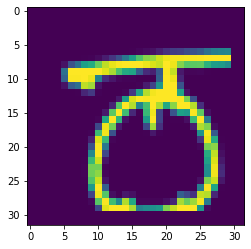

In [6]:
plt.imshow(train_data[4582,:].reshape(32,32))
plt.show()

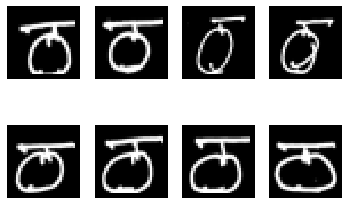

In [7]:
for i in range(1,9):
    plt.subplot(240+i)
    plt.axis('off')
    plt.imshow(train_data[4581+i,:].reshape(32,32), cmap='gray')
plt.show()

In [8]:
from collections import Counter
print(Counter(train_label[:,0]),end='\n\n')
print(Counter(test_label[:,0]))

Counter({0: 1700, 1: 1700, 2: 1700, 3: 1700, 4: 1700, 5: 1700, 6: 1700, 7: 1700, 8: 1700, 9: 1700, 10: 1700, 11: 1700, 12: 1700, 13: 1700, 14: 1700, 15: 1700, 16: 1700, 17: 1700, 18: 1700, 19: 1700, 20: 1700, 21: 1700, 22: 1700, 23: 1700, 24: 1700, 25: 1700, 26: 1700, 27: 1700, 28: 1700, 29: 1700, 30: 1700, 31: 1700, 32: 1700, 33: 1700, 34: 1700, 35: 1700, 36: 1700, 37: 1700, 38: 1700, 39: 1700, 40: 1700, 41: 1700, 42: 1700, 43: 1700, 44: 1700, 45: 1700})

Counter({0: 300, 1: 300, 2: 300, 3: 300, 4: 300, 5: 300, 6: 300, 7: 300, 8: 300, 9: 300, 10: 300, 11: 300, 12: 300, 13: 300, 14: 300, 15: 300, 16: 300, 17: 300, 18: 300, 19: 300, 20: 300, 21: 300, 22: 300, 23: 300, 24: 300, 25: 300, 26: 300, 27: 300, 28: 300, 29: 300, 30: 300, 31: 300, 32: 300, 33: 300, 34: 300, 35: 300, 36: 300, 37: 300, 38: 300, 39: 300, 40: 300, 41: 300, 42: 300, 43: 300, 44: 300, 45: 300})


In [9]:
print(np.max(train_data))  # data is already normalized
print(train_data[0,:].tolist())

1.0
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.10196078568696976, 0.2078431397676468, 0.18039216101169586, 0.125490203499794, 0.07450980693101883, 0.027450980618596077, 0.0117647061124444, 0.007843137718737125, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.003921568859368563, 0.0470588244497776, 0.09803921729326248, 0.027450980618596077, 0.0, 0.003921568859368563, 0.6313725709915161, 0.95686274766922, 0.9372549057006836, 0.8980392217636108, 0.8196078538894653, 0.6313725709915161, 0.46666666865348816, 0.38823530077934265, 0.0784313753247261, 0.019607843831181526, 0.003921568859368563, 0.0, 0.0, 0.0, 0.0

# lets save this data for future use.

In [ ]:
path = '../../DataSets/DevanagariHandwrittenCharacterDataset/'

train_data.tofile(path+'train_data.csv')
train_label.tofile(path+'train_labels.csv')

test_data.tofile(path+'test_data.csv')
test_label.tofile(path+'test_labels.csv')

# We use ANN to predict the label of each characters

In [10]:
# check total labels
labels = np.unique(train_label).size
labels

46

In [33]:
class NeuralNetwork():
    
    def __init__(self,lmda = 0):
        
        self.layers_n       = []
        self.theta_layers   = []
        self.bias           = []
        self.activation_func= []
        self.activations    = []
        self.lmda           = 0
        self.dL_dA          = []
        self.dL_dtheta      = []
        self.dL_dbias       = []
        self.itera          = []
        self.csfun          = []
        
    def add(self , neuron , activation_function = 'relu'):
        '''You have to give the no. of neurons you want to given layer.
            First layer neurons = no. of columns of your data
            
            default activation function is 'relu' you can change to 'sigmoid' , 'softmax' also
        '''
        self.layers_n.append(neuron)
        
        if activation_function == 'sigmoid' or activation_function == 'relu' or activation_function == 'softmax':
            self.activation_func.append(activation_function)
        
        else:
            raise TypeError('Pass only relu or sigmoid , and softmax for last layer')
    
    def one_hot_label(self , y):
        one_hot_labels = np.zeros((y.shape[0] , self.layers_n[-1]))
        for i in range(y.shape[0]):  
            one_hot_labels[i, y[i] ] = 1
        return one_hot_labels
    
    def softmax(self , activation , theta , bias):
        exp = np.exp( np.dot( activation , theta ) + bias)
        denominator = np.sum( exp , axis = 1)
        s = list(map(lambda i : exp[:,i] / denominator , np.arange(self.layers_n[-1])))
        return np.array(s).T
    
    def softmax2(self,X,theta,bias):
        expA = np.exp( np.dot(X,theta)+bias)
        return np.exp(expA) / np.sum(np.exp(expA), axis=0)
        
    def relu(self,activation,theta, bias):
        q = (np.dot(activation , theta) + bias)
        return np.clip(q , a_min=0 , a_max = q)
    
    def fit(self , X , y , batch_size = 128 , alpha = 0.01 , epoche = 100):
        for i in range(len(self.layers_n)-1): 
            
            self.theta_layers.append(np.random.randn(self.layers_n[i],self.layers_n[i+1]))
            self.bias.append(np.random.randn(self.layers_n[i+1]))
        
        return self.gradientDecent( X , y , batch_size , alpha , epoche )
    
    def sigmoid(self, activation , theta , bias):
        return  1 / (1 + np.exp(np.dot(activation , theta) +  bias))
    
    def forwardPropagation(self,X):
        
        self.activations.append(X)
        for i in range(len(self.layers_n)-2):
            
            self.activations.append(self.relu(self.activations[i] , self.theta_layers[i] , self.bias[i]))
                      
        self.activations.append(self.softmax2(self.activations[-1] , self.theta_layers[-1] , self.bias[-1]))
        
    def costFunction(self,X,y):
        self.y = self.one_hot_label(y)
        self.forwardPropagation(X)
        
        np.nan_to_num(self.activations[-1] , copy = False)
        self.crossEntropy = self.y * np.log(self.activations[-1])
        np.nan_to_num(self.crossEntropy, copy=False)
        
        #regu = self.lmda * (np.sum(self.theta_layer1)**2 + np.sum(self.theta_layer2)**2 + np.sum(self.theta_layer3)**2 + np.sum(self.theta_layer4)**2)
        return (1/X.shape[0] * -np.sum(self.crossEntropy)) #+ regu  # regu = 0 bcz lmda is zero 
      
    
    def costFunctionDerivative(self,X,y,alpha):
        
        self.y_cap = self.activations[-1]
        self.target_y = self.one_hot_label(y)
        
        self.dL_dA.append(self.y_cap - self.target_y)
        
        for i in range(len(self.layers_n)-2):   
            
            self.dL_dA.append( np.dot( self.dL_dA[i] , self.theta_layers[-1-i].T ) )
        
        for i in range(len(self.layers_n)-1):  
            
            # Storing derivative in a list
            self.dL_dtheta.append(1/X.shape[0] * (np.dot(self.activations[-2-i].T , self.dL_dA[i]))) 
            self.dL_dbias.append(1/X.shape[0] * self.dL_dA[i])
        
        for i in range(len(self.layers_n)-1):  
            
            # updating parameters
            self.theta_layers[i]    -= (alpha * self.dL_dtheta[-1-i])  
            self.bias[-1-i]         -= (alpha * self.dL_dbias[i].sum(axis = 0))                  
            
            # dont get confuse by [-1-i] . Actually derivative are calculated during backpropagation
            # and original values are initialized during forward propagation so derivative are stored in
            # reverse order while data's stored in forward order
      
    def gradientDecent(self , X , y , batch , alpha , epoche  ):
        i = 1
        while i < epoche:
        
            index = np.random.randint(0 , X.shape[0] , size=(batch,))
        
            initial_cost = self.costFunction(X[index] , y[index] )
       
            self.costFunctionDerivative(X[index], y[index],alpha )
        
            final_cost = self.costFunction(X[index] , y[index])
            
            print('Iteration {} Initial cost {} final cost {}'.format(i , initial_cost , final_cost))    
        
            self.itera.append(i)
            self.csfun.append(final_cost)
            i+=1
            
    def gradient_plot(self):
        plt.plot(self.itera,self.csfun)
         
        
    

In [36]:
del NN
NN = NeuralNetwork()
NN.add(1024)
NN.add(512)
NN.add(512)
NN.add(46)
NN.fit(train_data,train_label,alpha=.05,epoche=100,batch_size=2)

C:\Users\GirrajJangid\Anaconda3\envs\python_gpu\lib\site-packages\ipykernel_launcher.py:45: RuntimeWarning: invalid value encountered in true_divide
C:\Users\GirrajJangid\Anaconda3\envs\python_gpu\lib\site-packages\ipykernel_launcher.py:76: RuntimeWarning: divide by zero encountered in log
C:\Users\GirrajJangid\Anaconda3\envs\python_gpu\lib\site-packages\ipykernel_launcher.py:76: RuntimeWarning: invalid value encountered in multiply


Iteration 1 Initial cost 8.988465674311579e+307 final cost 8.988465674311579e+307
Iteration 2 Initial cost 0.6931471805599453 final cost 0.6931471805599453
Iteration 3 Initial cost 0.6931471805599453 final cost 0.6931471805599453
Iteration 4 Initial cost 0.6931471805599453 final cost 0.6931471805599453
Iteration 5 Initial cost inf final cost inf
Iteration 6 Initial cost 8.988465674311579e+307 final cost 8.988465674311579e+307
Iteration 7 Initial cost 8.988465674311579e+307 final cost 8.988465674311579e+307
Iteration 8 Initial cost 0.6931471805599453 final cost 0.6931471805599453
Iteration 9 Initial cost 8.988465674311579e+307 final cost 8.988465674311579e+307
Iteration 10 Initial cost 0.6931471805599453 final cost 0.6931471805599453
Iteration 11 Initial cost 0.6931471805599453 final cost 0.6931471805599453
Iteration 12 Initial cost 8.988465674311579e+307 final cost 8.988465674311579e+307
Iteration 13 Initial cost 0.6931471805599453 final cost 0.6931471805599453
Iteration 14 Initial cos

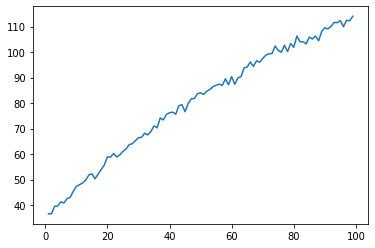

In [32]:
NN.gradient_plot()